In [1]:
## traditional registration

In [2]:
import SimpleITK as sitk
import os
from ipywidgets import interact, fixed
import matplotlib.pyplot as plt
import torchio as tio
from monai.transforms import Affine
from monai.data import ITKWriter
import nibabel as nib
import numpy as np
from scipy.ndimage import zoom
from medipy.metrics import dice

In [3]:
datapath = os.path.join('./Task02_Heart/generated_pairs_8/images/')
dataFiles  = sorted(os.listdir(datapath))
dataFiles = [i for i in dataFiles if not i.startswith('.')]
dataFiles = dataFiles[int(0.8*len(dataFiles)):]

In [4]:
case_name = dataFiles[0]
img_name = 'y.nii.gz'

In [5]:
moving_image = sitk.ReadImage(os.path.join('test_results_heart',case_name,'image_' + img_name))
moving_label = sitk.ReadImage(os.path.join('test_results_heart',case_name,'pre_seg_' + img_name))
fixed_image = sitk.ReadImage(os.path.join('test_results_heart',case_name,'gt_' + img_name))

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

from ipywidgets import interact, fixed
from IPython.display import clear_output

# Callback invoked by the interact IPython method for scrolling through the image stacks of
# the two images (moving and fixed).
def display_images(fixed_image_z, moving_image_z, fixed_npa, moving_npa):
    # Create a figure with two subplots and the specified size.
    plt.subplots(1,2,figsize=(10,8))
    
    # Draw the fixed image in the first subplot.
    plt.subplot(1,2,1)
    plt.imshow(fixed_npa[fixed_image_z,:,:],cmap=plt.cm.Greys_r);
    plt.title('fixed image')
    plt.axis('off')
    
    # Draw the moving image in the second subplot.
    plt.subplot(1,2,2)
    plt.imshow(moving_npa[moving_image_z,:,:],cmap=plt.cm.Greys_r);
    plt.title('moving image')
    plt.axis('off')
    
    plt.show()

# Callback invoked by the IPython interact method for scrolling and modifying the alpha blending
# of an image stack of two images that occupy the same physical space. 
def display_images_with_alpha(image_z, alpha, fixed, moving):
    img = (1.0 - alpha)*fixed[:,:,image_z] + alpha*moving[:,:,image_z] 
    plt.imshow(sitk.GetArrayViewFromImage(img),cmap=plt.cm.Greys_r);
    plt.axis('off')
    plt.show()
    
# Callback invoked when the StartEvent happens, sets up our new data.
def start_plot():
    global metric_values, multires_iterations
    
    metric_values = []
    multires_iterations = []

# Callback invoked when the EndEvent happens, do cleanup of data and figure.
def end_plot():
    global metric_values, multires_iterations
    
    del metric_values
    del multires_iterations
    # Close figure, we don't want to get a duplicate of the plot latter on.
    plt.close()

# Callback invoked when the IterationEvent happens, update our data and display new figure.
def plot_values(registration_method):
    global metric_values, multires_iterations
    
    metric_values.append(registration_method.GetMetricValue())                                       
    # Clear the output area (wait=True, to reduce flickering), and plot current data
    clear_output(wait=True)
    # Plot the similarity metric values
    plt.plot(metric_values, 'r')
    plt.plot(multires_iterations, [metric_values[index] for index in multires_iterations], 'b*')
    plt.xlabel('Iteration Number',fontsize=12)
    plt.ylabel('Metric Value',fontsize=12)
    plt.show()
    
# Callback invoked when the sitkMultiResolutionIterationEvent happens, update the index into the 
# metric_values list. 
def update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values))

In [7]:
initial_transform = sitk.CenteredTransformInitializer(fixed_image, 
                                                      moving_image, 
                                                      sitk.Euler3DTransform(), 
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)

#moving_resampled = sitk.Resample(moving_image, fixed_image, initial_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

#interact(display_images_with_alpha, image_z=(0,fixed_image.GetSize()[2]-1), alpha=(0.0,1.0,0.05), fixed = fixed(fixed_image), moving=fixed(moving_resampled));

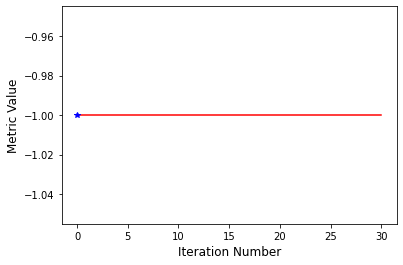

In [9]:
registration_method = sitk.ImageRegistrationMethod()

# Similarity metric settings.
registration_method.SetMetricAsCorrelation()
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(0.01)

registration_method.SetInterpolator(sitk.sitkLinear)

# Optimizer settings.
registration_method.SetOptimizerAsGradientDescent(learningRate=1, numberOfIterations=500, convergenceMinimumValue=1e-6, convergenceWindowSize=10)
registration_method.SetOptimizerScalesFromPhysicalShift()

# Setup for the multi-resolution framework.            
#registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
#registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
#registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Don't optimize in-place, we would possibly like to run this cell multiple times.
registration_method.SetInitialTransform(initial_transform, inPlace=False)

# Connect all of the observers so that we can perform plotting during registration.
registration_method.AddCommand(sitk.sitkStartEvent, start_plot)
registration_method.AddCommand(sitk.sitkEndEvent, end_plot)
registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations) 
registration_method.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(registration_method))

final_transform = registration_method.Execute(sitk.Cast(fixed_image, sitk.sitkFloat32), 
                                               sitk.Cast(moving_image, sitk.sitkFloat32))

In [15]:
moving_resampled = sitk.Resample(moving_image, fixed_image, final_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())
moving_resampled_label = sitk.Resample(moving_label, fixed_image, final_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())
sitk.WriteImage(moving_resampled_label, os.path.join('test_results_heart_16',case_name,'itk_resampled_mask_' + img_name))
sitk.WriteImage(moving_resampled, os.path.join('test_results_heart_16',case_name,'itk_resampled_image_'+ img_name))
interact(display_images_with_alpha, image_z=(0,fixed_image.GetSize()[2] - 1), alpha=(0.0,1.0,0.05), fixed = fixed(fixed_image), moving=fixed(moving_resampled));

interactive(children=(IntSlider(value=63, description='image_z', max=127), FloatSlider(value=0.5, description=…

In [12]:
mask = tio.ScalarImage(os.path.join('Task02_Heart','labelsTr',case_name+'.nii.gz'))
resample = tio.Resample((1,1,1),image_interpolation='nearest')
mask = resample(mask)
transform = tio.CropOrPad(
    (256, 256, 256),
)
mask = transform(mask).data
high_mask = mask

In [14]:
eval_mask= nib.load(os.path.join('./Task02_Heart/generated_pairs_16/masks/',case_name,img_name))
readdata1 = np.array(eval_mask.dataobj)
mask = np.expand_dims(readdata1,axis=0)
low_mask_x = zoom(mask,(1,1/2,1/2,1/2),order=1)

In [15]:
align_mask= nib.load(os.path.join('test_results_heart_16',case_name,'itk_resampled_mask_' + img_name))
pre_segA_x = np.array(align_mask.dataobj)
align_image= nib.load(os.path.join('test_results_heart_16',case_name,'itk_resampled_image_' + img_name))
align_image_x = np.array(align_image.dataobj)

In [16]:
print('dice for low resolution mask x')
print(dice(np.array(pre_segA_x)>0.5, np.array(low_mask_x[0])>0.1,nargout=1))
print('dice for high resolution mask x')
print(dice(np.array(zoom(pre_segA_x,(2,2,2),order=1))>0.5, np.array(high_mask[0])>0.1,nargout=1))

dice for low resolution mask x
[0.6963793]
dice for high resolution mask x
[0.76422608]


(-0.5, 127.5, 127.5, -0.5)

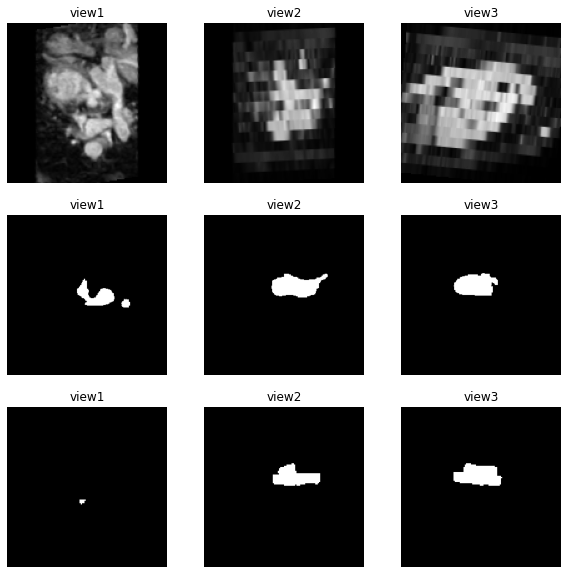

In [17]:
fig,a =  plt.subplots(3,3, figsize=(10,10))
a[0,0].imshow(align_image_x[64,:],cmap='gray')
a[0,0].set_title('view1')
a[0,0].axis('off')
a[0,1].imshow(align_image_x[:,64,:],cmap='gray')
a[0,1].set_title('view2')
a[0,1].axis('off')
a[0,2].imshow(align_image_x[:,:,64],cmap='gray')
a[0,2].set_title('view3')
a[0,2].axis('off')
a[1,0].imshow(high_mask[0,128,:]>0,cmap='gray')
a[1,0].set_title('view1')
a[1,0].axis('off')
a[1,1].imshow(high_mask[0,:,128,:]>0,cmap='gray')
a[1,1].set_title('view2')
a[1,1].axis('off')
a[1,2].imshow(high_mask[0,:,:,128]>0,cmap='gray')
a[1,2].set_title('view3')
a[1,2].axis('off')
a[2,0].imshow(pre_segA_x[64,:]>0.5,cmap='gray')
a[2,0].set_title('view1')
a[2,0].axis('off')
a[2,1].imshow(pre_segA_x[:,64,:]>0.5,cmap='gray')
a[2,1].set_title('view2')
a[2,1].axis('off')
a[2,2].imshow(pre_segA_x[:,:,64]>0.5,cmap='gray')
a[2,2].set_title('view3')
a[2,2].axis('off')

In [8]:
def align(moving_image,moving_label,fixed_image):
    initial_transform = sitk.CenteredTransformInitializer(fixed_image, 
                                                      moving_image, 
                                                      sitk.Euler3DTransform(), 
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)
   #interact(display_images_with_alpha, image_z=(0,fixed_image.GetSize()[2]-1), alpha=(0.0,1.0,0.05), fixed = fixed(fixed_image), moving=fixed(moving_resampled));
    registration_method = sitk.ImageRegistrationMethod()

    # Similarity metric settings.
    registration_method.SetMetricAsCorrelation()
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetMetricSamplingPercentage(0.01)

    registration_method.SetInterpolator(sitk.sitkLinear)

    # Optimizer settings.
    registration_method.SetOptimizerAsGradientDescent(learningRate=1, numberOfIterations=500, convergenceMinimumValue=1e-6, convergenceWindowSize=10)
    registration_method.SetOptimizerScalesFromPhysicalShift()

    # Setup for the multi-resolution framework.            
    #registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
    #registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
    #registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

    # Don't optimize in-place, we would possibly like to run this cell multiple times.
    registration_method.SetInitialTransform(initial_transform, inPlace=False)

    # Connect all of the observers so that we can perform plotting during registration.
    registration_method.AddCommand(sitk.sitkStartEvent, start_plot)
    registration_method.AddCommand(sitk.sitkEndEvent, end_plot)
    registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations) 
    registration_method.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(registration_method))

    final_transform = registration_method.Execute(sitk.Cast(fixed_image, sitk.sitkFloat32), 
                                                   sitk.Cast(moving_image, sitk.sitkFloat32))
    moving_resampled = sitk.Resample(moving_image, fixed_image, final_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())
    moving_resampled_label = sitk.Resample(moving_label, fixed_image, final_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID()) 
    return moving_resampled,moving_resampled_label,final_transform

In [9]:
dice_high_x = []
dice_high_y = []
dice_high_z = []

In [10]:
results_folder = 'test_onlyseg_results_heart'

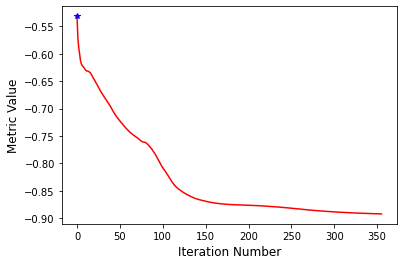

dice for high resolution mask z
[0.85955166]


In [11]:
for i in range(len(dataFiles)):
    case_name = dataFiles[i]
    mask = tio.ScalarImage(os.path.join('Task02_Heart','labelsTr',case_name+'.nii.gz'))
    resample = tio.Resample((1,1,1),image_interpolation='nearest')
    mask = resample(mask)
    transform = tio.CropOrPad(
        (256, 256, 256),
    )
    mask = transform(mask).data
    high_mask = mask

    img_name = 'x.nii.gz'
    #moving_image = sitk.ReadImage(os.path.join(results_folder,case_name,'image_' + img_name))
    moving_label = sitk.ReadImage(os.path.join(results_folder,case_name,'pre_seg_' + img_name))
    fixed_label = sitk.ReadImage(os.path.join(results_folder,case_name,'pre_seg_x.nii.gz'))
    moving_resampled,moving_resampled_label,final_transform = align(moving_label,moving_label,fixed_label)

    #moving_resampled = sitk.Resample(moving_image, fixed_image, final_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())
    moving_resampled_label = sitk.Resample(moving_label, fixed_label, final_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())
    sitk.WriteImage(moving_resampled_label, os.path.join(results_folder,case_name,'msk_resampled_mask_' + img_name))
    #sitk.WriteImage(moving_resampled, os.path.join(results_folder,case_name,'itk_resampled_image_' + img_name))


    align_mask= nib.load(os.path.join(results_folder,case_name,'msk_resampled_mask_'+ img_name))
    pre_segA_x = np.array(align_mask.dataobj)

    print('dice for high resolution mask x')
    dice_now = dice(np.array(zoom(pre_segA_x,(2,2,2),order=1))>0.5, np.array(high_mask[0])>0.1,nargout=1)
    dice_high_x.append(dice_now[0])
    print(dice_now)

    img_name = 'y.nii.gz'
    #moving_image = sitk.ReadImage(os.path.join(results_folder,case_name,'image_' + img_name))
    moving_label = sitk.ReadImage(os.path.join(results_folder,case_name,'pre_seg_' + img_name))
    fixed_label = sitk.ReadImage(os.path.join(results_folder,case_name,'pre_seg_x.nii.gz'))
    moving_resampled,moving_resampled_label,final_transform = align(moving_label,moving_label,fixed_label)

    #moving_resampled = sitk.Resample(moving_image, fixed_image, final_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())
    moving_resampled_label = sitk.Resample(moving_label, fixed_label, final_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())
    sitk.WriteImage(moving_resampled_label, os.path.join(results_folder,case_name,'msk_resampled_mask_' + img_name))
    #sitk.WriteImage(moving_resampled, os.path.join(results_folder,case_name,'itk_resampled_image_' + img_name))


    align_mask= nib.load(os.path.join(results_folder,case_name,'msk_resampled_mask_'+ img_name))
    pre_segA_y = np.array(align_mask.dataobj)

    print('dice for high resolution mask y')
    dice_now = dice(np.array(zoom(pre_segA_y,(2,2,2),order=1))>0.5, np.array(high_mask[0])>0.1,nargout=1)
    dice_high_y.append(dice_now[0])
    print(dice_now)

    img_name = 'z.nii.gz'
    #moving_image = sitk.ReadImage(os.path.join(results_folder,case_name,'image_' + img_name))
    moving_label = sitk.ReadImage(os.path.join(results_folder,case_name,'pre_seg_' + img_name))
    fixed_label = sitk.ReadImage(os.path.join(results_folder,case_name,'pre_seg_x.nii.gz'))
    moving_resampled,moving_resampled_label,final_transform = align(moving_label,moving_label,fixed_label)

    #moving_resampled = sitk.Resample(moving_image, fixed_image, final_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())
    moving_resampled_label = sitk.Resample(moving_label, fixed_label, final_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())
    sitk.WriteImage(moving_resampled_label, os.path.join(results_folder,case_name,'msk_resampled_mask_' + img_name))
    #sitk.WriteImage(moving_resampled, os.path.join(results_folder,case_name,'itk_resampled_image_' + img_name))


    align_mask= nib.load(os.path.join(results_folder,case_name,'msk_resampled_mask_'+ img_name))
    pre_segA_z = np.array(align_mask.dataobj)

    print('dice for high resolution mask z')
    dice_now = dice(np.array(zoom(pre_segA_z,(2,2,2),order=1))>0.5, np.array(high_mask[0])>0.1,nargout=1)
    dice_high_z.append(dice_now[0])
    print(dice_now)

In [150]:
np.array(dice_overlap_yz).mean()

0.8814270457151768

In [13]:
dice_overlap_xy = []
dice_overlap_xz = []
dice_overlap_yz = []
for i in range(len(dataFiles)):
    case_name = dataFiles[i]
    img_name = 'x.nii.gz'
    align_mask= nib.load(os.path.join(results_folder,case_name,'itk_resampled_mask_'+ img_name))
    pre_segA_x = np.array(align_mask.dataobj)
    img_name = 'y.nii.gz'
    align_mask= nib.load(os.path.join(results_folder,case_name,'itk_resampled_mask_'+ img_name))
    pre_segA_y = np.array(align_mask.dataobj)
    img_name = 'z.nii.gz'
    align_mask= nib.load(os.path.join(results_folder,case_name,'itk_resampled_mask_'+ img_name))
    pre_segA_z = np.array(align_mask.dataobj)
    dice_overlap = dice(np.array(pre_segA_x)>0.5, np.array(pre_segA_y)>0.5,nargout=1)
    dice_overlap_xy.append(dice_overlap[0])
    print('dice for overlap x and y')
    print(dice_overlap[0])
    dice_overlap = dice(np.array(pre_segA_x)>0.5, np.array(pre_segA_z)>0.5,nargout=1)
    dice_overlap_xz.append(dice_overlap[0])
    print('dice for overlap x and z')
    print(dice_overlap[0])
    dice_overlap = dice(np.array(pre_segA_y)>0.5, np.array(pre_segA_z)>0.5,nargout=1)
    dice_overlap_yz.append(dice_overlap[0])
    print('dice for overlap y and z')
    print(dice_overlap[0])

dice for overlap x and y
0.7818189061068398
dice for overlap x and z
0.7867305907825549
dice for overlap y and z
0.8081412015234039
dice for overlap x and y
0.8035896255875875
dice for overlap x and z
0.7463772910739099
dice for overlap y and z
0.7292219927215501
dice for overlap x and y
0.770252754374595
dice for overlap x and z
0.7819941285201696
dice for overlap y and z
0.8299080277052344
dice for overlap x and y
0.7441568345969225
dice for overlap x and z
0.7721234055700225
dice for overlap y and z
0.8229838353502341
